# Training VAE and GAN model

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

MNIST dataset을 활용해 VAE, GAN 모델을 간단하게 구현해보는 것이 이번 과제입니다.

# Imports and set seed

In [1]:
!pip install ipywidgets -q
# !jupyter nbextension enable --py widgetsnbextension -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


In [2]:
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import datasets, transforms
import torchvision.utils as vutils
from IPython.display import display
import ipywidgets as widgets
from PIL import Image

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)

set_seed(1)

# VAE Implementation

### 1. Model design  - Problem 1

---

$Enc$, $Dec$ 모델을 자유롭게 구성해보세요.

CNN 기반 아키텍쳐나 ViT 기반 아키텍쳐를 자유롭게 구성해도 좋습니다.

이때 각 아키텍쳐 선택 요소에 맞게 epoch이나 여러 학습 파라미터를 Main training loop에서 수정해주셔야 합니다.

입출력 $\text{dim}$에 맞게 세팅하는 것에 유의해주세요.

---


CNN base

In [10]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim = 32):
        super(ConvEncoder, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 1, padding = 1, bias = False), # (1, 28, 28) -> (64, 24, 24)
            nn.BatchNorm2d(num_features = 64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, 7, 1, 1), # -> (128, 20, 20)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, 4, 2, 1), # -> (128, 10, 10)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

        )

        self.flattened_size = 128 * 10 * 10
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

    def forward(self, x):
      h = self.convs(x)
      h = h.view(h.size(0), -1)
      return self.fc_mu(h), self.fc_logvar(h)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim = 32):
        super(ConvDecoder, self).__init__()
        self.unflatten_shape = (128, 10, 10)
        self.fc = nn.Linear(latent_dim, 128 * 10 * 10)

        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 7, 1, 1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 1, 7, 1, 1),
        )

    def forward(self, z):
      h = self.fc(z)
      h = h.view(-1, *self.unflatten_shape)
      return self.deconvs(h)

reparameterization 과정에 대해 확인해보세요.

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


### 2. Loss

---

$(\text{Binary Cross Entropy + KL Divergence})$의 구조입니다.

KLD term이 아래와 같은 방식으로 구해지는 이유에 대해 생각해보세요.

In [12]:
def vae_loss(x, recon_logits, mu, logvar, reduction='mean'):
    BCE = F.binary_cross_entropy_with_logits(recon_logits, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    if reduction == 'mean':
        div = x.size(0)
        BCE = BCE / div
        KLD = KLD / div
    return BCE + KLD, BCE, KLD

### 3. Visualization function

---

실행만 하고 넘어가시면 됩니다.

In [8]:
def save_step_images(model, step, imgs, z):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        recon_logits, _, _ = model(imgs)
        recon = torch.sigmoid(recon_logits)

        recon_grid = torch.cat([imgs, recon], dim=0)
        recon_grid = vutils.make_grid(recon_grid, nrow=4, normalize=True, pad_value=1)
        vutils.save_image(recon_grid, f"vae_recon_imgs/recon_{step:05d}.png")

        gen = torch.sigmoid(model.decoder(z))
        gen_grid = vutils.make_grid(gen, nrow=4, normalize=True, pad_value=1)
        vutils.save_image(gen_grid, f"vae_gen_imgs/gen_{step:05d}.png")

    if was_training:
        model.train(was_training)

## 4. Main train loop

---

batch size, epoch, learning rate와

VAE latent dimension을 자유롭게 조절하면서 학습시켜보세요.

In [14]:
#------------------------ Settings ------------------------#
latent_dim = 32

batch_size = 512
num_epochs = 20
learning_rate = 1e-4

#------------------------ Data & Dataloader ------------------------#
transform = transforms.Compose([transforms.ToTensor(),])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
    )

#------------------------ Models & Optimizers ------------------------#
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE(latent_dim=latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scaler = torch.amp.GradScaler('cuda')

In [15]:
# for visualization
os.makedirs("vae_recon_imgs", exist_ok=True)
os.makedirs("vae_gen_imgs", exist_ok=True)
fixed_imgs, _ = next(iter(train_loader))
fixed_imgs = fixed_imgs[:4].to(device)
fixed_z = torch.randn(4, latent_dim).to(device)

global_step = 0
bce_losses, kld_losses = [], []
for epoch in (range(num_epochs)):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            recon, mu, logvar = model(x)
            loss, bce, kld = vae_loss(x, recon, mu, logvar)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        bce_losses.append(bce.item())
        kld_losses.append(kld.item())

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        if global_step % 100 == 0:
            with torch.no_grad():
                save_step_images(model, step=global_step, imgs=fixed_imgs, z=fixed_z)

        global_step += 1



Epoch 19: 100%|██████████| 118/118 [00:17<00:00,  6.89it/s, loss=105.8811]


## 5. Results visualization

---

아래 코드는 실행만 하면 됩니다. 바를 조절해 iteration별 학습 과정을 확인할 수 있습니다.

In [16]:
def load_step_images(step, recon_dir='vae_recon_imgs', gen_dir='vae_gen_imgs'):
    recon_path = os.path.join(recon_dir, f'recon_{step:05d}.png')
    gen_path = os.path.join(gen_dir, f'gen_{step:05d}.png')
    return Image.open(recon_path), Image.open(gen_path)

def show_images(step):
    recon_img, gen_img = load_step_images(step)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(recon_img)
    axs[0].set_title(f"Recon Step {step}")
    axs[0].axis('off')

    axs[1].imshow(gen_img)
    axs[1].set_title(f"Gen Step {step}")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

saved_steps = sorted([
    int(f.split('_')[-1].split('.')[0])
    for f in os.listdir('vae_recon_imgs') if f.endswith('.png')
])

step_slider = widgets.IntSlider(
    value=saved_steps[0],
    min=min(saved_steps),
    max=max(saved_steps),
    step=100,
    description='Step:',
    continuous_update=False
)

# widgets.interact(show_images, step=step_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='Step:', max=2300, step=100), Ou…

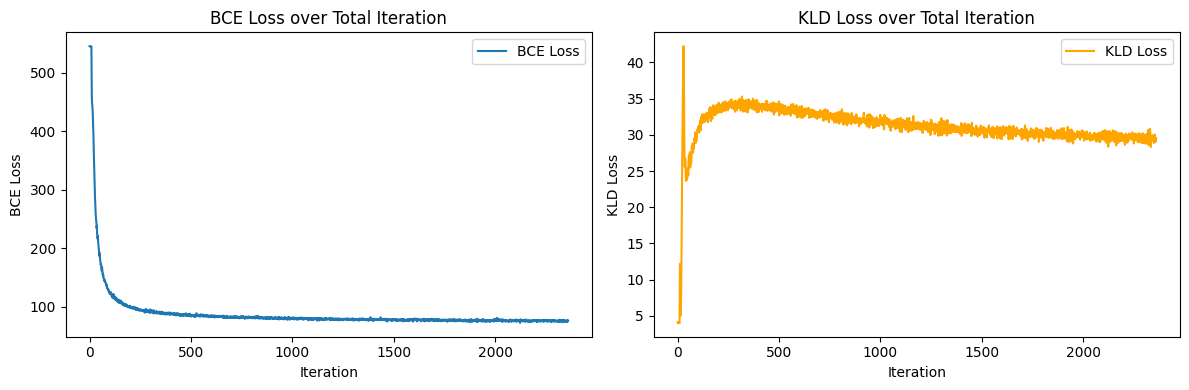

In [17]:
widgets.interact(show_images, step=step_slider);
print('\n')
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# BCE Loss subplot
axs[0].plot(bce_losses, label='BCE Loss')
axs[0].set_title('BCE Loss over Total Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('BCE Loss')
axs[0].legend()

# KLD Loss subplot
axs[1].plot(kld_losses, label='KLD Loss', color='orange')
axs[1].set_title('KLD Loss over Total Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('KLD Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


---
___

# GAN Implementation

## 1. Model Design - Problem 2

---

$Generator$, $Discriminator$ 모델을 자유롭게 구성해보세요. 입출력 $\text{dim}$에 맞게 세팅하는 것에 유의해주세요.

In [28]:
# Generator

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels = z_dim, out_channels = 128, kernel_size = 7, stride = 1, padding = 0, bias = False), # -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False), # -> (1, 28, 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 7, stride = 1, padding = 0, bias = False), # (1, 28, 28) -> (32, 22, 22)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(32, 64, 5, 2, 1, bias = False), # -> (64, 10, 10)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,128, 5, 2, 1, bias = False), # (128, 4, 4)
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 1, 4, 2, 0, bias = False), # -> (1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

## 2. Visualization fuction

---

In [12]:
def save_step_images_for_gan(model, step, z):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        fake = model(z).detach()
        # fake = (fake + 1) / 2  # [-1, 1] → [0, 1]
        gen_grid = vutils.make_grid(fake, nrow=4, normalize=True, pad_value=1)
        vutils.save_image(gen_grid, f"gan_gen_imgs/gen_{step:05d}.png")
    if was_training:
        model.train(was_training)

## 3. Main training loop

---

In [30]:
#------------------------ Settings ------------------------#
z_dim = 100

batch_size = 512
num_epochs = 15
learning_rate = 2e-4

#------------------------ Data & Dataloader ------------------------#
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])  # [-1,1] range scaling
])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

#------------------------ Models & Optimizers ------------------------#
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator(z_dim).to(device)
D = Discriminator().to(device)
opt_G = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [31]:
os.makedirs("gan_gen_imgs", exist_ok=True)
fixed_z = torch.randn(4, z_dim, 1, 1, device=device)

global_step = 0
D_losses, G_losses = [], []
for epoch in range(20):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for x, _ in pbar:
        x = x.to(device)
        batch_size = x.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = G(z).detach()

        opt_D.zero_grad()
        loss_real = loss_fn(D(x), torch.ones(batch_size, 1, device=device))
        loss_fake = loss_fn(D(fake), torch.zeros(batch_size, 1, device=device))
        loss_D = (loss_real + loss_fake)
        D_losses.append(loss_D.item())
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = G(z)
        opt_G.zero_grad()
        loss_G = loss_fn(D(fake), torch.ones(batch_size, 1, device=device))
        G_losses.append(loss_G.item())
        loss_G.backward()
        opt_G.step()

        pbar.set_postfix({"D_loss": f"{loss_D.item():.4f}", "G_loss": f"{loss_G.item():.4f}"})

        if global_step % 100 == 0:
            with torch.no_grad():
                save_step_images_for_gan(G, step=global_step, z=fixed_z)

        global_step += 1

Epoch 19: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s, D_loss=3.0394, G_loss=0.1169]


## 4. Visualization

---

In [11]:
def load_step_images(step, gen_dir='gan_gen_imgs'):
    gen_path = os.path.join(gen_dir, f'gen_{step:05d}.png')
    gen_img = Image.open(gen_path)
    return gen_img

def show_images(step):
    gen_img = load_step_images(step)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(gen_img)
    ax.set_title(f"Gen Step {step}\n(fixed z shown)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

if os.path.exists('gan_gen_imgs'):
    saved_steps = sorted([
        int(f.split('_')[-1].split('.')[0])
        for f in os.listdir('gan_gen_imgs') if f.endswith('.png')
    ])

    if saved_steps:
        step_slider = widgets.IntSlider(
            value=saved_steps[0],
            min=min(saved_steps),
            max=max(saved_steps),
            step=100,
            description='Step:',
            continuous_update=False
        )

        # widgets.interact(show_images, step=step_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Step:', max=2300, step=100), Ou…

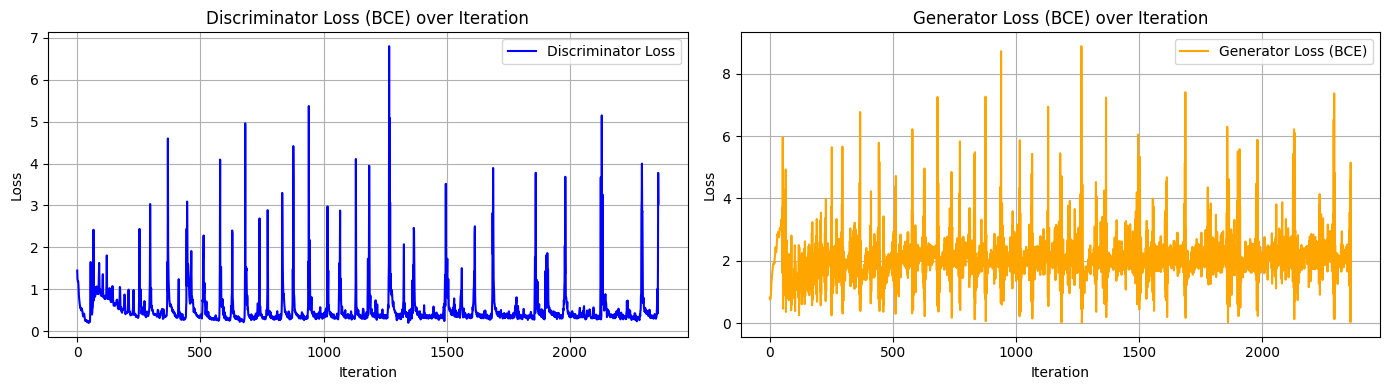

In [33]:
widgets.interact(show_images, step=step_slider);
print('\n')
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

axs[0].plot(D_losses, label='Discriminator Loss', color='blue')
axs[0].set_title('Discriminator Loss (BCE) over Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(G_losses, label='Generator Loss (BCE)', color='orange')
axs[1].set_title('Generator Loss (BCE) over Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 1. Model Design - Problem 2 with ViT

In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_chans=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # -> (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, N_patches, embed_dim)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

# Generator
class ViTGenerator(nn.Module):
    def __init__(self, z_dim=100, img_size=28, patch_size=4, embed_dim=128, depth=4, num_heads=4):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.linear = nn.Linear(z_dim, self.num_patches * embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.to_img = nn.Linear(embed_dim, patch_size * patch_size)

        self.img_size = img_size
        self.patch_size = patch_size

    def forward(self, z):
        x = self.linear(z).view(z.size(0), self.num_patches, -1)  # (B, N, embed_dim)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        x = self.to_img(x)  # (B, N, patch^2)
        x = x.view(-1, 1, self.img_size, self.img_size)
        return torch.tanh(x)

# Discriminator
class ViTDiscriminator(nn.Module):
    def __init__(self, img_size=28, patch_size=4, embed_dim=128, depth=4, num_heads=4):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, 1, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2, embed_dim))
        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, img):
        x = self.patch_embed(img)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # global average pooling over patches
        return torch.sigmoid(self.fc(x))


## 3. Main training loop

ViT trainig loop

In [14]:
#------------------------ Settings ------------------------#
z_dim = 100

batch_size = 128
num_epochs = 30
learning_rate = 1e-5

#------------------------ Data & Dataloader ------------------------#
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])  # [-1,1] range scaling
])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

#------------------------ Models & Optimizers ------------------------#
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = ViTGenerator(z_dim).to(device)
D = ViTDiscriminator().to(device)
opt_G = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [15]:
os.makedirs("gan_gen_imgs", exist_ok=True)
fixed_z = torch.randn(4, z_dim, device=device)

global_step = 0
D_losses, G_losses = [], []


for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for x, _ in pbar:
        x = x.to(device)
        batch_size = x.size(0)

        # -------- Train Discriminator -------- #
        z = torch.randn(batch_size, z_dim, device=device)
        fake = G(z).detach()

        opt_D.zero_grad()
        loss_real = loss_fn(D(x), torch.ones(batch_size, 1, device=device))
        loss_fake = loss_fn(D(fake), torch.zeros(batch_size, 1, device=device))
        loss_D = (loss_real + loss_fake)
        D_losses.append(loss_D.item())
        loss_D.backward()
        opt_D.step()

        # -------- Train Generator -------- #
        z = torch.randn(batch_size, z_dim, device=device)
        fake = G(z)
        opt_G.zero_grad()
        loss_G = loss_fn(D(fake), torch.ones(batch_size, 1, device=device))
        G_losses.append(loss_G.item())
        loss_G.backward()
        opt_G.step()

        # -------- Logging -------- #
        pbar.set_postfix({"D_loss": f"{loss_D.item():.4f}", "G_loss": f"{loss_G.item():.4f}"})

        if global_step % 100 == 0:
            with torch.no_grad():
                save_step_images_for_gan(G, step=global_step, z = fixed_z)

        global_step += 1


## My colab cannot run GPU at the moment,
## will again run it at some point 😅 when GPU can again get assigned

Epoch 1/30:  40%|███▉      | 186/469 [13:16<20:12,  4.28s/it, D_loss=0.2006, G_loss=3.8735]


KeyboardInterrupt: 

## 4. Visualization

In [ ]:
widgets.interact(show_images, step=step_slider);
print('\n')
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

axs[0].plot(D_losses, label='Discriminator Loss', color='blue')
axs[0].set_title('Discriminator Loss (BCE) over Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(G_losses, label='Generator Loss (BCE)', color='orange')
axs[1].set_title('Generator Loss (BCE) over Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()